<a href="https://colab.research.google.com/github/crea0414/1st_CVDL/blob/master/Day020_Classic_CNN_ResNet%E3%80%81InceptionV4%E3%80%81Inception_ResNet_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 『本次練習內容』
#### 學習如何搭建 Residual Block
####  學習如何搭建Inception-ResNet中的 Inception Block

## 『本次練習目的』
  #### 了解 Residual Block原理
  #### 了解如何結合Inception 與 Residual概念

---

In [1]:
import tensorflow as tf
tf.__version__

'2.3.0'

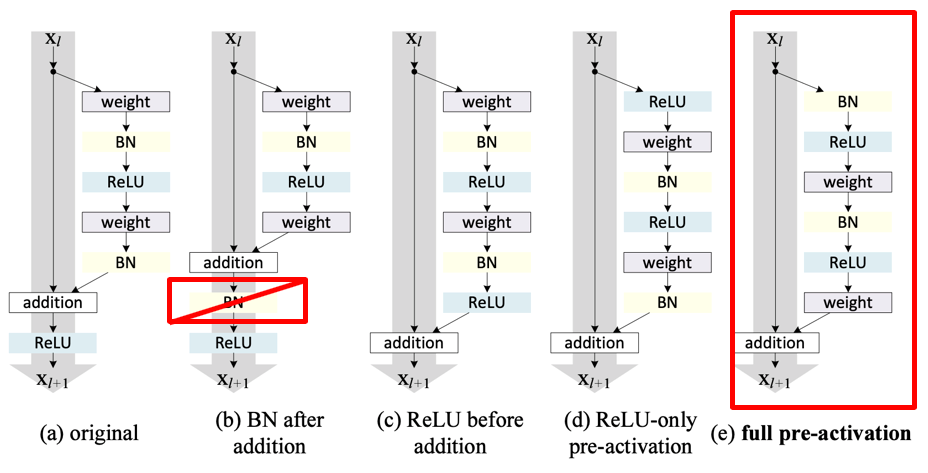

# Residual Block V1

In [2]:
# residual block v1
class ResidualBlock_v1(tf.keras.layers.Layer):
    def __init__(self, filter, kernel_size, stage_name=None, block_name=None, **kwargs):
        super(ResidualBlock_v1, self).__init__(**kwargs)
        self.stage = stage_name
        self.block = block_name
        self.filter = filter
        self.kernel_size = kernel_size
    
    def build(self, input_shape):
        self.conv_1 = tf.keras.layers.Conv2D(self.filter, (1, 1), 
                                             name='res_convA_'+self.stage + '_' + self.block+'_branch')
        self.bn_1 = tf.keras.layers.BatchNormalization(name='res_bnA_'+self.stage + '_' + self.block+'_branch')
        self.conv_2 = tf.keras.layers.Conv2D(input_shape[-1], self.kernel_size, 
                                             padding='same',
                                            name='res_convB_'+self.stage + '_' + self.block+'_branch')
        self.bn_2 = tf.keras.layers.BatchNormalization(name='res_bnB_'+self.stage + '_' + self.block+'_branch')
        
    #@tf.function
    def call(self, inputs):
        #print('tracing!')
        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = tf.add(x, inputs)
        return tf.nn.relu(x)


In [3]:
#check 
tf.keras.backend.clear_session()
res_block = ResidualBlock_v1(128, (3, 3), stage_name='test', block_name='vgg')

model = tf.keras.Sequential([res_block])
output = model(tf.random.normal((1, 224, 224, 3)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
residual_block_v1 (ResidualB (1, 224, 224, 3)          4495      
Total params: 4,495
Trainable params: 4,233
Non-trainable params: 262
_________________________________________________________________


In [4]:
(3*1+1)*128 + 128*4 + \
(128*9+1)*3 + 3*4 

4495

# Residual Block V2

In [5]:
class ResidualBlock_v2(tf.keras.layers.Layer):
    def __init__(self, filter, kernel_size, **kwargs):
        super(ResidualBlock_v2, self).__init__(**kwargs)
        self.filter = filter
        self.kernel_size = kernel_size
    
    def build(self, input_shape):
        self.bn_1 = tf.keras.layers.BatchNormalization(input_shape=input_shape)
        self.relu_1 = tf.keras.layers.Activation('relu')
        self.conv_1 = tf.keras.layers.Conv2D(self.filter, (1, 1))
        self.bn_2 = tf.keras.layers.BatchNormalization()
        self.relu_2 = tf.keras.layers.Activation('relu')
        self.conv_2 = tf.keras.layers.Conv2D(input_shape[-1], self.kernel_size, 
                                             padding='same') 

    def call(self, inputs):
        x = self.bn_1(inputs)
        x = self.relu_1(x)
        x = self.conv_1(x)
        x = self.bn_2(x)
        x = self.relu_2(x)
        x = self.conv_2(x)
        return tf.add(x, inputs)       

In [6]:
tf.keras.backend.clear_session()

residual_block = ResidualBlock_v2(128, (3, 3))
model = tf.keras.Sequential([residual_block])
output = model(tf.random.normal((1, 224, 224, 3)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
residual_block_v2 (ResidualB (1, 224, 224, 3)          4495      
Total params: 4,495
Trainable params: 4,233
Non-trainable params: 262
_________________________________________________________________


In [7]:
3*4 + (3*1+1)*128 + \
128*4 + (128*9+1)*3

4495

# Residual_Block v2 filter

In [8]:
class ResidualBlock_v2_filter(tf.keras.layers.Layer):
    def __init__(self, kernel_size=(3, 3), reduce_filter=96, output_filter=128, **kwargs):
        super(ResidualBlock_v2_filter, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.reduce_filter = reduce_filter
        self.output_filter = output_filter

    def build(self, input_shape):
        # skip branch
        self.bn0 = tf.keras.layers.BatchNormalization(input_shape=input_shape)
        self.relu0 = tf.keras.layers.Activation('relu')
        self.conv_0 = tf.keras.layers.Conv2D(self.output_filter, (1, 1))
        # residual branch
        self.bn1 = tf.keras.layers.BatchNormalization(input_shape=input_shape)
        self.relu1 = tf.keras.layers.Activation('relu')
        self.conv_1 = tf.keras.layers.Conv2D(self.reduce_filter, (1, 1))
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.Activation('relu')
        self.conv_2 = tf.keras.layers.Conv2D(self.reduce_filter, self.kernel_size, padding='same')
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.relu3 = tf.keras.layers.Activation('relu')
        self.conv_3 = tf.keras.layers.Conv2D(self.output_filter, (1, 1))
     
    def call(self, inputs):
        x0 = self.bn0(inputs)
        x0 = self.relu0(x0)
        x0 = self.conv_0(x0)

        x = self.bn1(inputs)
        x = self.relu1(x)
        x = self.conv_1(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv_2(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv_3(x)

        x = tf.keras.layers.add([x, x0])
        return x

In [9]:
tf.keras.backend.clear_session()

residual_block = ResidualBlock_v2_filter(output_filter=256)
model = tf.keras.Sequential([residual_block])
output = model(tf.random.normal((1, 224, 224, 3)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
residual_block_v2_filter (Re (1, 224, 224, 256)        110072    
Total params: 110,072
Trainable params: 109,676
Non-trainable params: 396
_________________________________________________________________


## Part1
```
import numpy as np
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras import backend as K
from keras import layers
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Lambda
```

## ResNetV1

In [10]:
def Residual_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = tf.keras.layers.Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(x)
   

    x = tf.keras.layers.add([x, input_tensor])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [11]:
tf.keras.backend.clear_session()
inputs = tf.keras.layers.Input((224, 224, 3))
outputs = Residual_block(inputs, (3, 3), (128, 3, 1), 'test', 'A')
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
restestA_branch2a (Conv2D)      (None, 224, 224, 128 512         input_1[0][0]                    
__________________________________________________________________________________________________
bntestA_branch2a (BatchNormaliz (None, 224, 224, 128 512         restestA_branch2a[0][0]          
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 128 0           bntestA_branch2a[0][0]           
_______________________________________________________________________________________

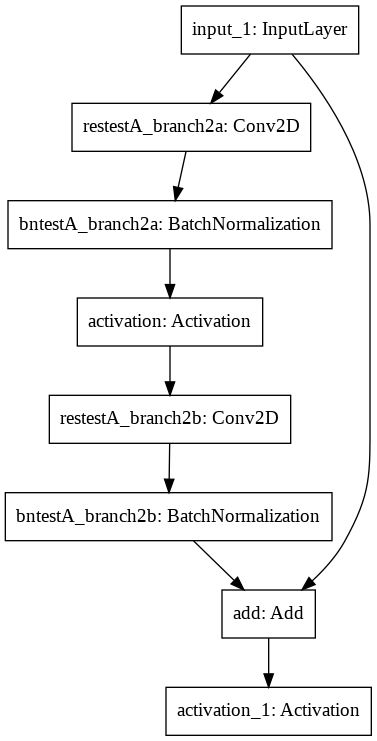

In [12]:
tf.keras.utils.plot_model(model)

## 參考ResNetV1 搭建 ResNetV2版本的Residual Block

In [13]:
def Residual_block_v2(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    '''搭建V2版本Block'''
    x = tf.keras.layers.BatchNormalization(name=bn_name_base+'2a')(input_tensor)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters1, (1, 1), name=conv_name_base+'2a')(x)
    x = tf.keras.layers.BatchNormalization(name=bn_name_base+'2b')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters3, kernel_size, padding='same',
                                name=conv_name_base+'2b',
                               )(x)
    x = tf.keras.layers.add([x, inputs])
    return x

    

In [14]:
tf.keras.backend.clear_session()
inputs = tf.keras.layers.Input((224, 224, 3))
outputs = Residual_block_v2(inputs, (3, 3), (128, 256, 3), 'test', 'A')
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
bntestA_branch2a (BatchNormaliz (None, 224, 224, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 3)  0           bntestA_branch2a[0][0]           
__________________________________________________________________________________________________
restestA_branch2a (Conv2D)      (None, 224, 224, 128 512         activation[0][0]                 
_______________________________________________________________________________________

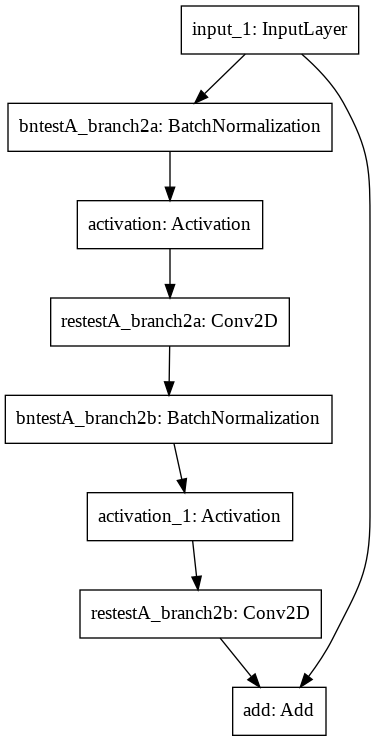

In [15]:
tf.keras.utils.plot_model(model)

## 試試看自己設計一個先壓縮再回放的V2 Block

In [16]:
def Residual_block_filter(input_tensor, kernel_size, reduce_size=96, output_size=128):
    #skip connection
    #expaned output channels by 1x1 kernel
    x1 = tf.keras.layers.Conv2D(output_size, (1, 1))(input_tensor)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    
    #residual branch
    #1.squeeze feature map size by 1x1 kernel
    x = tf.keras.layers.Conv2D(reduce_size, (1, 1))(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    #2.custom kernel size operation
    x = tf.keras.layers.Conv2D(reduce_size, kernel_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    #3.expaned output channels by 1x1 kernel
    x = tf.keras.layers.Conv2D(output_size, (1, 1))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    #add
    x = tf.keras.layers.add([x, x1])
    x = tf.keras.layers.Activation('relu')(x)
    return x


In [17]:
tf.keras.backend.clear_session()
inputs = tf.keras.layers.Input((224, 224, 3))
outputs = Residual_block_filter(inputs, (3, 3), reduce_size=96, output_size=128)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 96) 384         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 96) 384         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 96) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

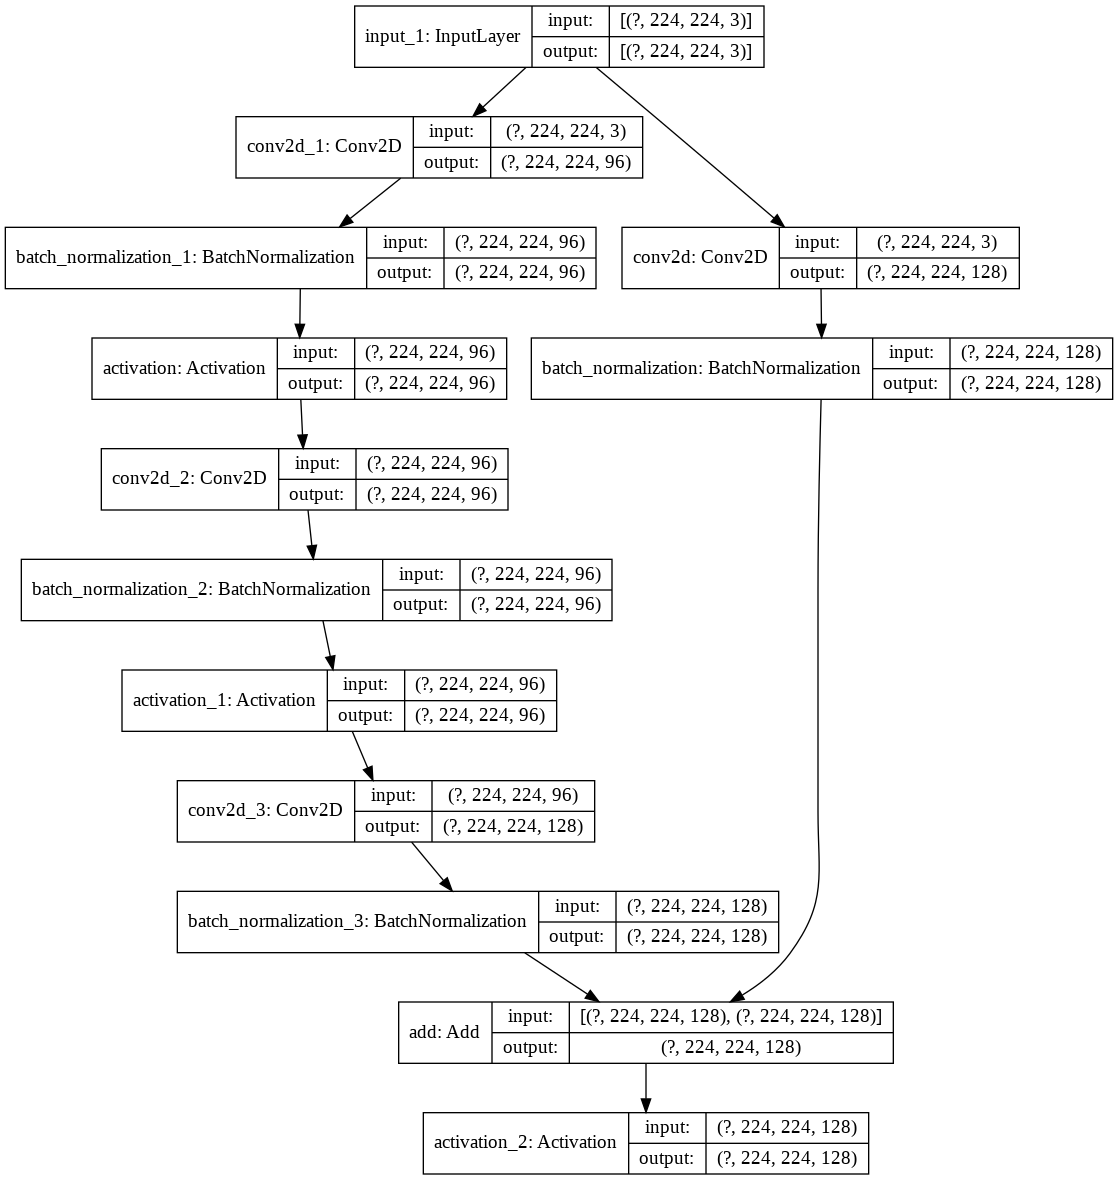

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
def Residual_block_v2_filter(input_tensor, kernel_size, reduce_size=96, output_size=128):
    #skip connection
    #expaned output channels by 1x1 kernel
    x1 = tf.keras.layers.BatchNormalization()(input_tensor)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Conv2D(output_size, (1, 1))(x1)
    
    #residual branch
    #1.squeeze feature map size by 1x1 kernel
    x = tf.keras.layers.BatchNormalization()(input_tensor)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(reduce_size, (1, 1))(x)
   
    #2.custom kernel size operation
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(reduce_size, kernel_size, padding='same')(x)
  
    #3.expaned output channels by 1x1 kernel
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(output_size, (1, 1))(x)
    
    #add
    x = tf.keras.layers.add([x, x1])
    return x

In [20]:
tf.keras.backend.clear_session()
inputs = tf.keras.layers.Input((224, 224, 3))
outputs = Residual_block_v2_filter(inputs, (3, 3), reduce_size=96, output_size=128)
model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 3)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 96) 384         activation_1[0][0]               
_______________________________________________________________________________________

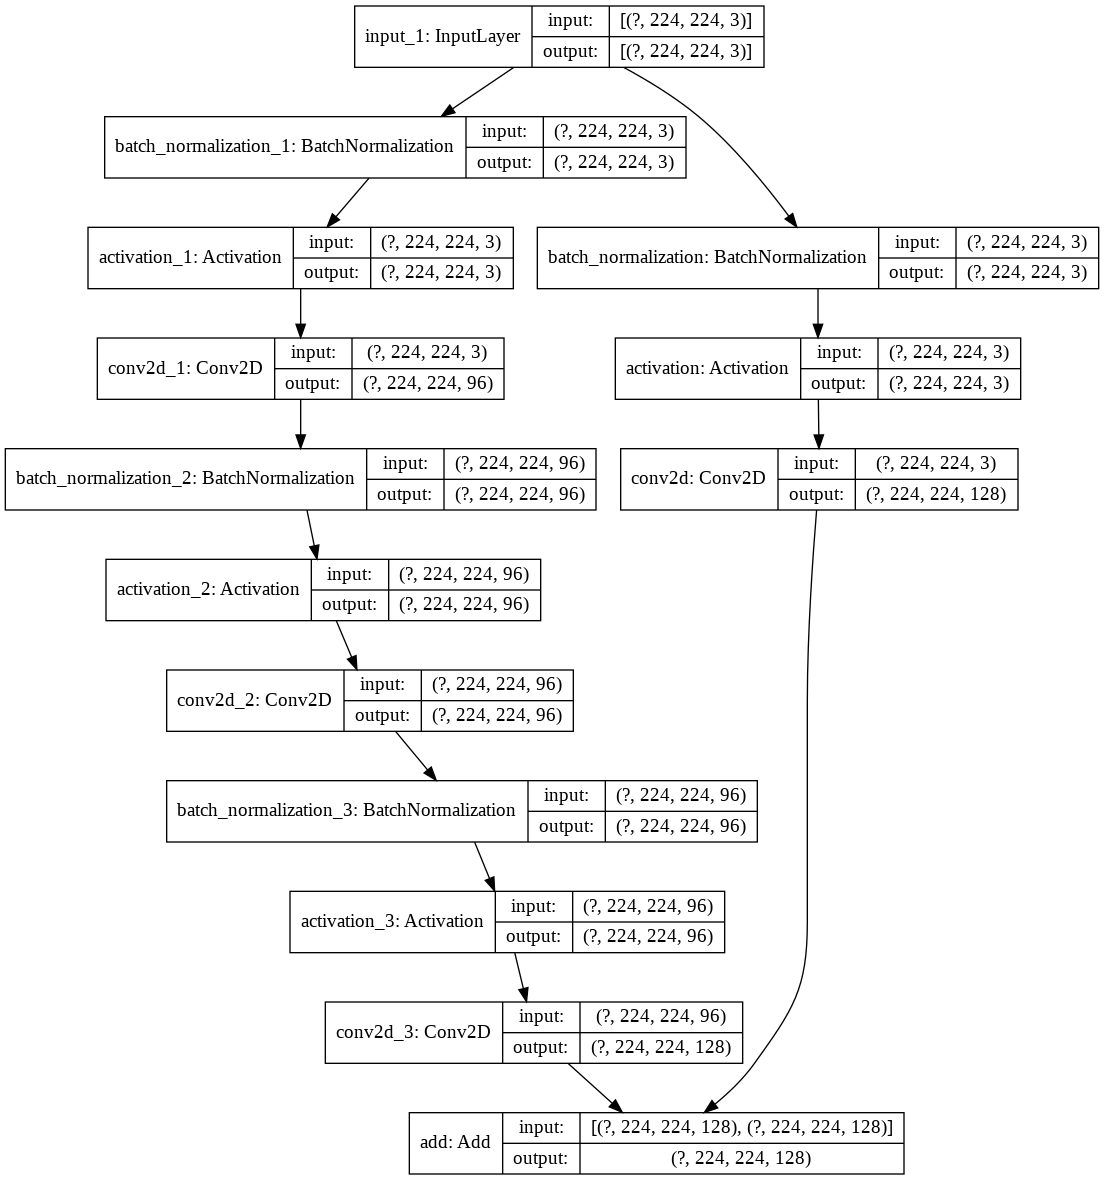

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

---

## Part2

## Incpetion Block-A

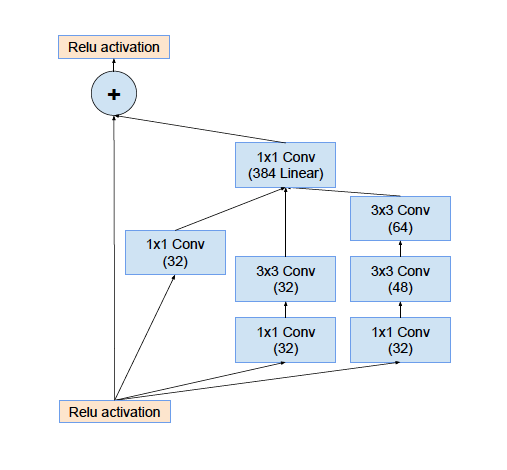

## Incpetion Block-B

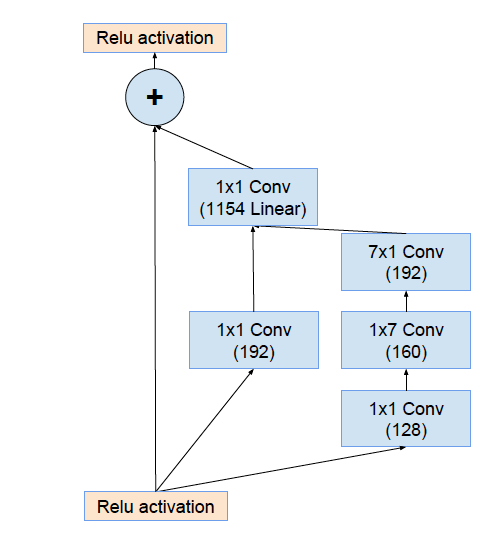

## Incpetion Block-C

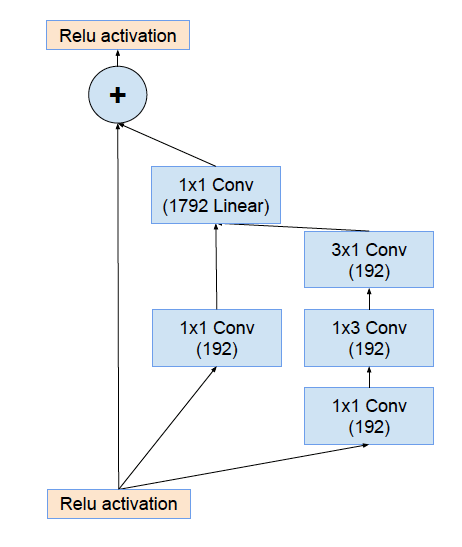

In [22]:
import tensorflow.keras.backend as K

In [23]:
#[Note] Conv layer without bias and BatchNorm layer withon scale parameter

def Conv2d_bn(x,filters,kernel_size,padding='same',strides=(1, 1),normalizer=True,activation='relu',name=None):
    if name is not None:
        conv_name = name + '_conv'
        bn_name = name + '_bn'
        act_name = name + '_act'
    else:
        conv_name = None
        bn_name = None
        act_name = None
    if K.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    x = tf.keras.layers.Conv2D(
            filters, kernel_size,
            strides=strides, padding=padding,
            use_bias=False, name=conv_name)(x)
    if normalizer:
        x = tf.keras.layers.BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    if activation:
        x = tf.keras.layers.Activation(activation, name=act_name)(x)
    return x

In [24]:
def Residual_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = tf.keras.layers.Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(x)
    x = tf.keras.layersActivation('relu')(x)

    x = tf.keras.layers.Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(x)

    x = tf.keras.layers.add([x, input_tensor])
    x = tf.keras.layers.Activation('relu')(x)
    return x

## 參考上方Residual_block搭建 Inception-ResNet中的Inception Block

In [25]:
def inception_resnet_block(x, scale, block_type, activation='relu'):
    '''scale: scaling factor to scale the residuals (i.e., the output of
            passing `x` through an inception module) before adding them
            to the shortcut branch. Let `r` be the output from the residual branch,
            the output of this block will be `x + scale * r`.(簡單來說就是控制Residual branch的比例)'''
    if block_type == 'Incpetion_Block-A':
        branch_0 = Conv2d_bn(x, 32, (1, 1))
        branch_1 = Conv2d_bn(x, 32, (1, 1))
        branch_1 = Conv2d_bn(branch_1, 32, (3, 3))
        branch_2 = Conv2d_bn(x, 32, (1, 1))
        branch_2 = Conv2d_bn(branch_2, 48, (3, 3))
        branch_2 = Conv2d_bn(branch_2, 64, (3, 3))
        branches = [branch_0, branch_1, branch_2]
    elif block_type == 'Incpetion_Block-B':
        branch_0 = Conv2d_bn(x, 192, (1, 1))
        branch_1 = Conv2d_bn(x, 128, (1, 1))
        branch_1 = Conv2d_bn(branch_1, 160, (1, 7))
        branch_1 = Conv2d_bn(branch_1, 192, (7, 1))
        branches = [branch_0, branch_1]
    elif block_type == 'Incpetion_Block-C':
        branch_0 = Conv2d_bn(x, 192, (1, 1))
        branch_1 = Conv2d_bn(x, 192, (1, 1))
        branch_1 = Conv2d_bn(branch_1, 192, (1, 3))
        branch_1 = Conv2d_bn(branch_1, 192, (3, 1))
        branches = [branch_0, branch_1]
    else:
        raise ValueError('Unknown Inception-ResNet block type. '
                         'Expects "block35", "block17" or "block8", '
                         'but got: ' + str(block_type))
    mixed = tf.keras.layers.Concatenate(axis=3)(branches)
    
    '''確保輸入跟輸出深度相同'''
    up = Conv2d_bn(mixed, K.int_shape(x)[3], (1, 1), activation=None)
    
    '''導入殘差結構，並給予權重'''
    
    x = tf.keras.layers.Lambda(lambda inputs, scale: inputs[0]+ inputs[1] * scale, ##提示inputs[0]、inputs[1]
               output_shape=K.int_shape(x)[1:],
               arguments={'scale': scale}, )([x, up])
    
    if activation is not None:
        x = tf.keras.layers.Activation(activation)(x)
    return x


In [26]:
img_input = tf.keras.layers.Input(shape=(224,224,32))
x=inception_resnet_block(img_input, 0.1, 'Incpetion_Block-A', activation='relu')
print(x)

Tensor("activation_10/Relu:0", shape=(None, 224, 224, 32), dtype=float32)


## 測試

In [27]:
img_input = tf.keras.layers.Input(shape=(224,224,32))
x=inception_resnet_block(img_input, 0.1, 'Incpetion_Block-A', activation='relu')
print(x)

Tensor("activation_17/Relu:0", shape=(None, 224, 224, 32), dtype=float32)


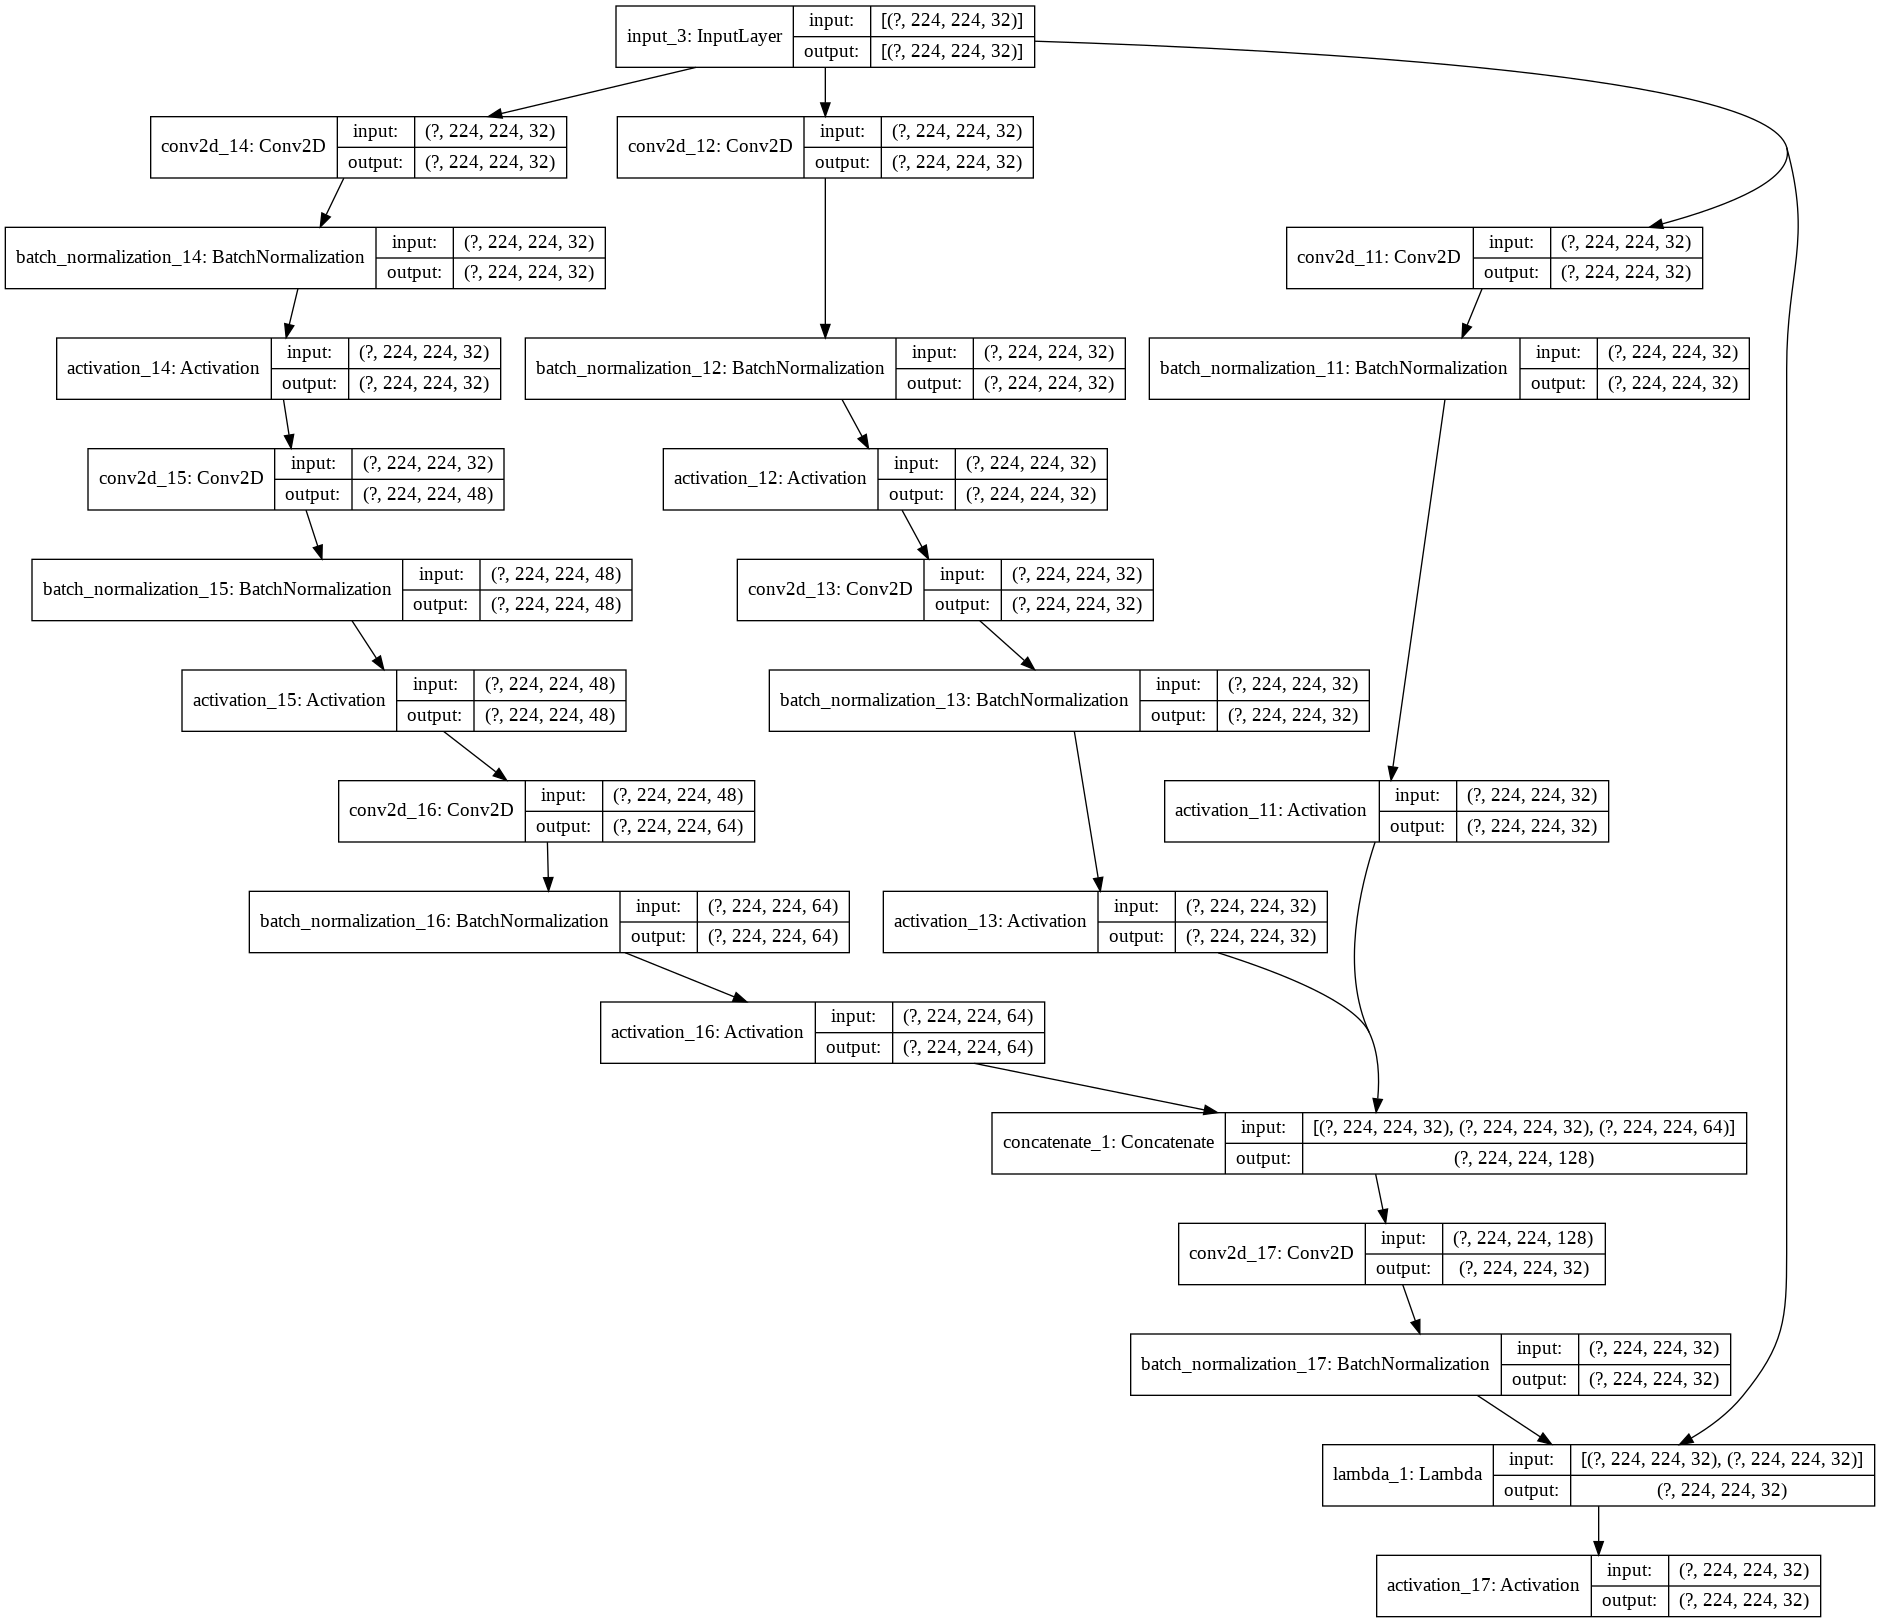

In [28]:
tf.keras.backend.clear_session()
model = tf.keras.Model(img_input, x)
tf.keras.utils.plot_model(model, show_shapes=True)

In [29]:
img_input = tf.keras.layers.Input(shape=(224,224,32))
x=inception_resnet_block(img_input, 0.1, 'Incpetion_Block-B', activation='relu')
print(x)

Tensor("activation_4/Relu:0", shape=(None, 224, 224, 32), dtype=float32)


In [30]:
img_input = tf.keras.layers.Input(shape=(224,224,32))
x=inception_resnet_block(img_input, 0.1, 'Incpetion_Block-C', activation='relu')
print(x)

Tensor("activation_9/Relu:0", shape=(None, 224, 224, 32), dtype=float32)


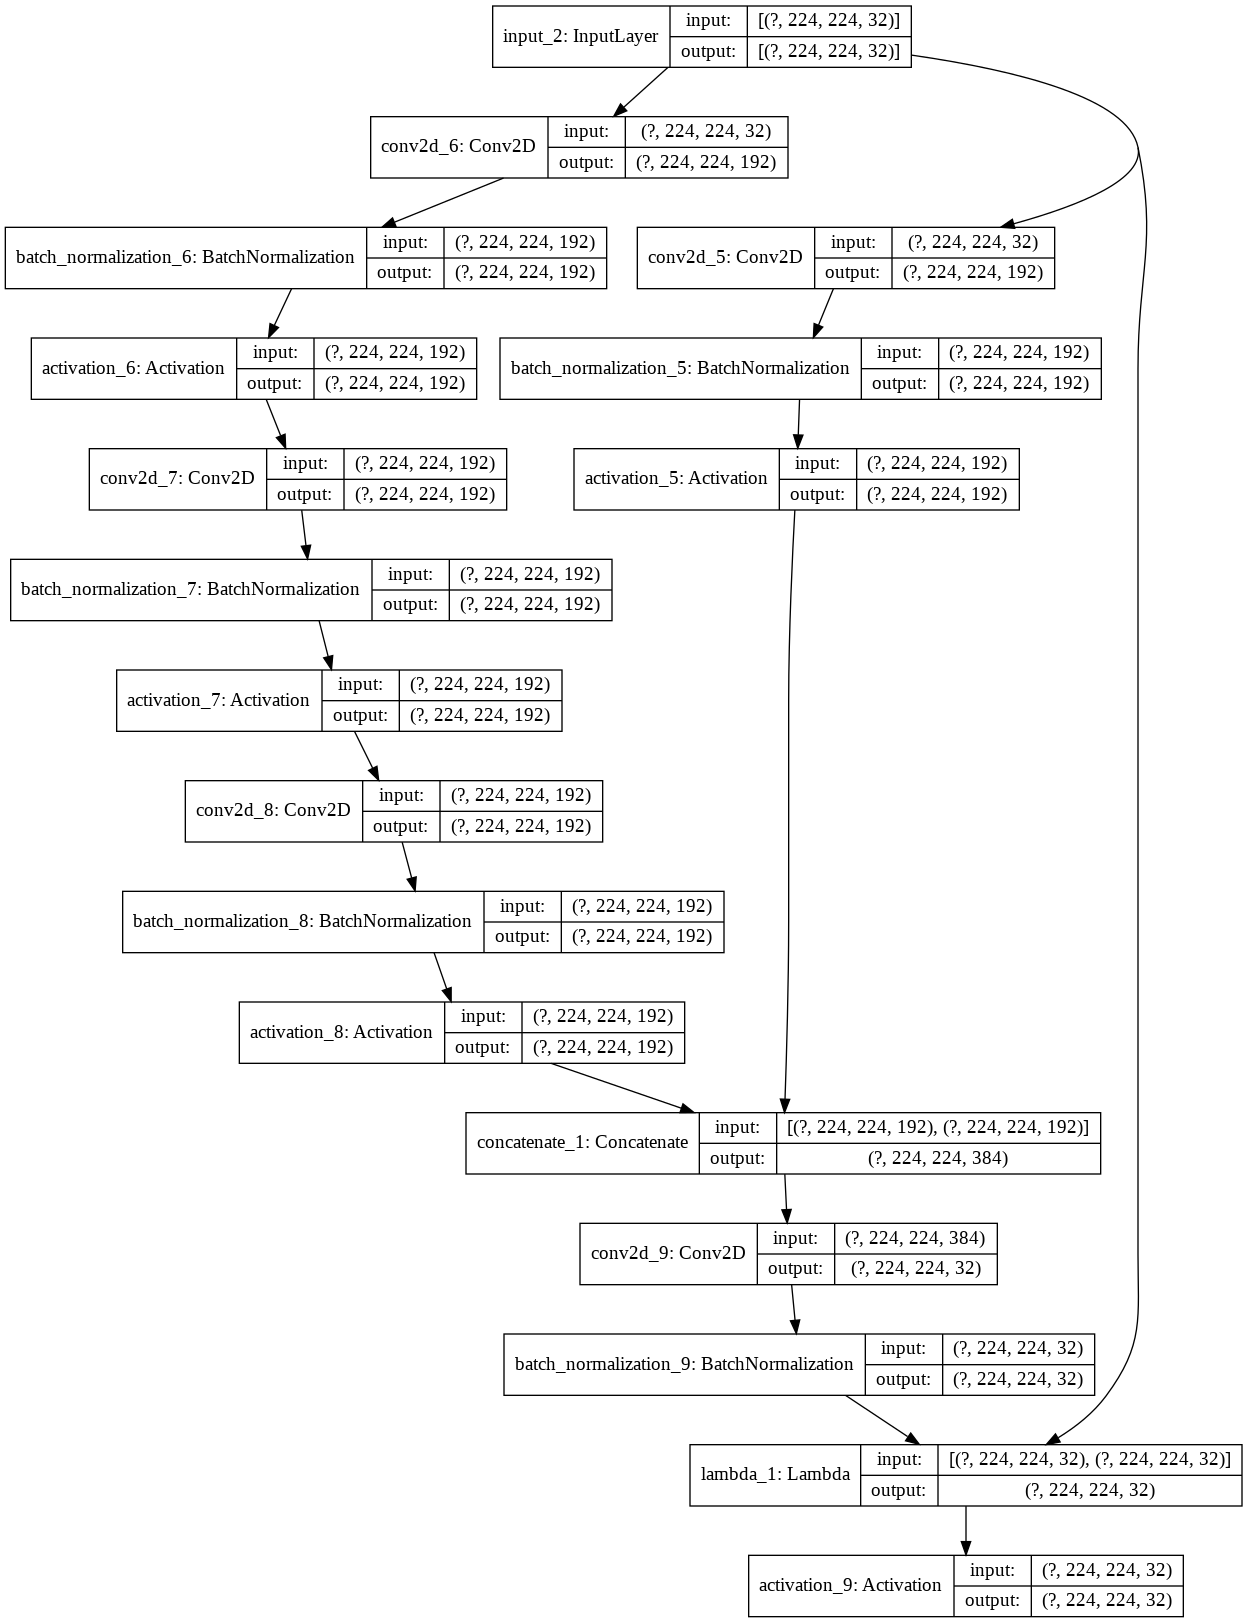

In [31]:
tf.keras.backend.clear_session()
model = tf.keras.Model(img_input, x)
tf.keras.utils.plot_model(model, show_shapes=True)

## 嘗試導入Inception Block到 Vgg_Inception中

In [32]:
def InceptionV1_block(x, specs,channel_axis, name):
    (br0, br1, br2, br3) = specs   # ((64,), (96,128), (16,32), (32,))
    branch_0 = Conv2d_bn(x, br0[0], (1, 1), name=name+"_Branch_0")

    branch_1 = Conv2d_bn(x, br1[0], (1, 1), name=name+"_Branch_1")
    branch_1 = Conv2d_bn(branch_1, br1[1], (3, 3), name=name+"_Branch_1_1")

    '''Branch_2'''
    branch_2 = Conv2d_bn(x, br2[0], (1, 1), name=name+"_Branch_2")
    branch_2 = Conv2d_bn(branch_2, br2[1], (3, 3), name=name+"_Branch_2_1")

    '''Branch_3'''
    branch_3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3,), strides=(1, 1), padding='same')(x)
    branch_3 = Conv2d_bn(branch_3, br3[0], (1, 1), name=name+"_Branch_3")
    x = tf.keras.layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name=name+"_Concatenated")
    return x
    
def InceptionV3_block(x, specs, channel_axis, name):
    (br0, br1, br2, br3) = specs   # ((64,), (96,128), (16,32), (32,))
    branch_0 = Conv2d_bn(x, br0[0], (1, 1), name=name+"_Branch_0")

    branch_1 = Conv2d_bn(x, br1[0], (1, 1), name=name+"_Branch_1")
    branch_1 = Conv2d_bn(branch_1, br1[1], (1, 3), name=name+"_Branch_1_1")
    branch_1 = Conv2d_bn(branch_1, br1[1], (3, 1), name=name+"_Branch_1_2")

    '''Branch_2'''
    branch_2 = Conv2d_bn(x, br2[0], (1, 1), name=name+"_Branch_2")
    branch_2 = Conv2d_bn(branch_2, br2[1], (1, 3), name=name+"_Branch_2_1")
    branch_2 = Conv2d_bn(branch_2, br2[1], (3, 1), name=name+"_Branch_2_2")
    '''Branch_3'''
    branch_3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    branch_3 = Conv2d_bn(branch_3, br3[0], (1, 1), name=name+"_Branch_3")

    x = tf.keras.layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name=name+"_Concatenated")
    return x

In [33]:
def VGG16_ResNet_Inception(include_top=True,input_tensor=None, input_shape=(224,224,1),
          pooling='max',classes=1000):
 
    img_input = tf.keras.layers.Input(shape=input_shape)
    
    x = Conv2d_bn(img_input,64, (3, 3), activation='relu', padding='same', name='block1_conv1')
    x = Conv2d_bn(x,64, (3, 3), activation='relu', padding='same', name='block1_conv2')
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2d_bn(x,128, (3, 3), activation='relu', padding='same', name='block2_conv1')
    x = Conv2d_bn(x,128, (3, 3), activation='relu', padding='same', name='block2_conv2')
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = InceptionV1_block(x, ((64,), (96,128), (16,32), (32,)), 3, 'Block_1')
    x = InceptionV1_block(x, ((64,), (96,128), (16,32), (32,)), 3, 'Block_2')
    x = InceptionV1_block(x, ((64,), (96,128), (16,32), (32,)), 3, 'Block_3')
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2d_bn(x,512, (3, 3), activation='relu', padding='same', name='block4_conv1')
    x = Conv2d_bn(x,512, (3, 3), activation='relu', padding='same', name='block4_conv2')
    x = Conv2d_bn(x,512, (3, 3), activation='relu', padding='same', name='block4_conv3')
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5 
    #為什麼要加InceptionV3_block 原因?
    x =InceptionV3_block(x, ((128,), (192,256), (32,64), (64,)), 3, 'Block_4')
    x =InceptionV3_block(x, ((128,), (192,256), (32,64), (64,)), 3, 'Block_5')
    x =InceptionV3_block(x, ((128,), (192,256), (32,64), (64,)), 3, 'Block_6')
    x =tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = tf.keras.layers.Flatten(name='flatten')(x)
        x = tf,keras.layers.Dense(4096, activation='relu', name='fc1')(x)
        x = tf.keras.layers.Dense(4096, activation='relu', name='fc2')(x)
        x = tf.keras.layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
       #可以提醒學員為什麼要加avg或是max
        if pooling == 'avg':
            x = tf.keras.layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = tf.keras.layers.GlobalMaxPooling2D()(x)

    inputs = img_input
    # Create model.
    model = tf.keras.Model(inputs, x, name='vgg16')

   
    return model



In [34]:
model = VGG16_ResNet_Inception(include_top=False)

In [35]:
model.summary()

Model: "vgg16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1_conv (Conv2D)      (None, 224, 224, 64) 576         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 224, 224, 64) 192         block1_conv1_conv[0][0]          
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 224, 224, 64) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________